In [ ]:
from wikipedia import *
from operator import itemgetter
import requests
anchor2concept('Hello')

In [ ]:
id2title(48324759L)

In [ ]:
"""
Testing the Solr splitting
"""

import requests
import json
from wikipedia import *
from __future__ import division
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"

def get_solr_count(s):
    """ Gets the number of documents the string occurs 
        NOTE: Multi words should be quoted
    Arg:
        s: the string (can contain AND, OR, ..)
    Returns:
        The number of documents
    """

    q='+text:(\"%s\")'%(s,)
    qstr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'indent':'on', 'wt':'json', 'q':q, 'rows':0}
    r = requests.get(qstr, params=params)
    try:
        if 'response' not in r.json():
            return 0
        else:
            return r.json()['response']['numFound']
    except:
        return 0

def get_mention_count(s):
    """
    Description:
        Returns the amount of times that the given string appears as a mention in wikipedia.
    Args:
        s: the string (can contain AND, OR, ..)
    Return:
        The amount of times the given string appears as a mention in wikipedia
    """
    
    result = anchor2concept(s)
    rSum = 0
    for item in result:
        rSum += item[1]
        
    return rSum

def getTextMentions(line):
    """
    Description:
        A helper method to get the mentions in an evaluable format, includes the mentions'
        start and end.
    Args:
        line: The json data that has info that needs to be converted.
    Return:
        The mentions in the form [[start, end, text],...].
    """
    
    mentions = []
    curWord = 0 
    curStart = 0
    for mention in line['mentions']:
        while curWord < mention[0]:
            curStart += len(line['text'][curWord]) + 1
            curWord += 1
        mentions.append([curStart, curStart + len(line['text'][curWord]), line['text'][curWord]])
        
    return mentions

def destroyExclusiveOverlaps(textData):
    """
    Description:
        Removes all overlaps from text data, so that only the best mention in an
        overlap set is left.
    Args:
        textData: [[start, end, text, anchProb],...]
    Return:
        textData minus the unesescary parts of the overlapping
    """
    
    newTextData = [] # textData minus the unesescary parts of the overlapping
    overlappingSets = [] # stores arrays of the indexes of overlapping items from textData
    
    # creates the overlappingSets array
    i = 0
    while i < len(textData)-1:
        # even single elements considered overlapping set
        # this is root of overlapping set
        overlappingSets.append([i])
        overlapIndex = len(overlappingSets) - 1
        theBegin = textData[i][0]
        
        # look at next words untill not overlap
        for j in range(i+1, len(textData)):
            # if next word starts before endiest one ends
            if textData[j][0] == theBegin:
                overlappingSets[overlapIndex].append(j)
                i = j # make sure not to repeat overlap set
            else:
                # add final word
                if j == len(textData) - 1:
                    overlappingSets.append([j])
                break
        i += 1
                    
    # get only the best overlapping element of each set
    for oSet in overlappingSets:
        bestIndex = 0
        bestScore = -1
        for i in oSet:
            totalMentions = get_mention_count(textData[i][2])
            totalAppearances = get_solr_count(textData[i][2].replace(".", ""))
            if totalAppearances == 0:
                score = 0
            else:
                score = totalMentions/totalAppearances
            
            if score > bestScore:
                bestScore = score
                bestIndex = i
        
        # put right item in new textData
        newTextData.append(textData[bestIndex])
        
    return newTextData
                    
def getSolrMentions(text):
    """
    Description:
        A method to split the text and try to extract mentions using Solr.
    Args:
        text: The text to find mentions in.
    Return:
        The mentions as found from our method using Solr.
    """
    
    addr = 'http://localhost:8983/solr/enwikianchors20160305/tag'
    params={'overlaps':'ALL', 'tagsLimit':'5000', 'fl':'id','wt':'json','indent':'on'}
    r = requests.post(addr, params=params, data=text.encode('utf-8'))
    textData0 = r.json()['tags']
    
    textData = []
    # get rid of extra un-needed Solr data, and add in anchor probability
    for item in textData0:
        totalMentions = get_mention_count(text[item[1]:item[3]])
        totalAppearances = get_solr_count(text[item[1]:item[3]].replace(".", ""))
        if totalAppearances == 0:
            anchorProb = 0
        else:
            anchorProb = totalMentions/totalAppearances
        
        # put in the new clean textData
        textData.append([item[1], item[3], text[item[1]:item[3]], anchorProb])
    
    textData = destroyExclusiveOverlaps(textData)
    
    # gets the POS labels for the words
    postrs = []
    for item in textData:
        postrs.append(item[2])
    postrs = nltk.pos_tag(postrs)
    for i in range(0,len(textData)):
        textData[i].append(postrs[i]) # [4][1] is index of type of word
    
    mentions = []
    mentionPThrsh = 0.001
    
    for item in textData:
        if (item[3] >= mentionPThrsh
                and (item[4][1][0:2] == 'NN' or item[4][1] == 'JJ')):
            mentions.append([item[0], item[1], item[2]])
    
    return mentions

def precision(trueMentions, otherMentions):
    """
    Description:
        Calculates the precision of otherSet against the trueMentions.
    Args:
        trueMentions: The 'right' answers for what the mentions are.
        otherMentions: Our mentions obtained through some means.
    Return:
        The precision: (# of correct mentions)/(# of found mentions)
    """
    
    numFound = len(otherMentions)
    numCorrect = 0 # incremented in for loop
    
    trueIndex = 0
    otherIndex = 0
    
    while trueIndex < len(trueMentions) and otherIndex < len(otherMentions):
        # if mentions start and end on the same
        if (trueMentions[trueIndex][0] == otherMentions[otherIndex][0]
               and trueMentions[trueIndex][1] == otherMentions[otherIndex][1]):
            #print ('MATCH: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <===> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            numCorrect += 1
            trueIndex += 1
            otherIndex += 1
        # if true mention starts before the other starts
        elif trueMentions[trueIndex][0] < otherMentions[otherIndex][0]:
            #print ('FAIL: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <XXX> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            trueIndex += 1
        # if other mention starts before the true starts (same doesnt matter)
        elif trueMentions[trueIndex][0] >= otherMentions[otherIndex][0]:
            #print ('FAIL: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <XXX> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            otherIndex += 1
        else:
            print 'AAAAAAAHHHHHHHHHHHHHHHHHHHHHHHHHHHHH!!!!!!!!!!!!!!!!!!!'

    print 'correct: ' + str(numCorrect) + '\nfound: ' + str(numFound)
    if numFound == 0:
        return 0
    else:
        return (numCorrect/numFound)

def recall(trueMentions, otherMentions):
    """
    Description:
        Calculates the recall of otherSet against the trueMentions.
    Args:
        trueMentions: The 'right' answers for what the mentions are.
        otherMentions: Our mentions obtained through some means.
    Return:
        The recall: (# of correct entities)/(# of actual entities)
    """
    
    numActual = len(trueMentions)
    numCorrect = 0 # incremented in for loop)
    
    trueIndex = 0
    otherIndex = 0
    
    while trueIndex < len(trueMentions) and otherIndex < len(otherMentions):
        # if mentions start and end on the same
        if (trueMentions[trueIndex][0] == otherMentions[otherIndex][0]
               and trueMentions[trueIndex][1] == otherMentions[otherIndex][1]):
            numCorrect += 1
            trueIndex += 1
            otherIndex += 1
        # if true mention starts before the other starts
        elif trueMentions[trueIndex][0] < otherMentions[otherIndex][0]:
            trueIndex += 1
        # if other mention starts before the true starts (same doesnt matter)
        elif trueMentions[trueIndex][0] >= otherMentions[otherIndex][0]:
            otherIndex += 1
        
    print 'correct: ' + str(numCorrect) + '\nactual: ' + str(numActual)
    if numActual == 0:
        return 0
    else:
        return (numCorrect/numActual)

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
    
    # reset counters
    totalPrec = 0
    totalRec = 0
    totalLines = 0

    # each method tests all lines
    for line in dataLines:

        print str(totalLines + 1)

        trueMentions = getTextMentions(line)
        solrMentions = getSolrMentions(" ".join(line['text']))
        
        print line['text']
        print trueMentions
        print str(solrMentions) + '\n'
        
        """solrMentions0 = tagme.mentions(" ".join(line['text']))
        solrMentions = []
        for item in solrMentions0.mentions:
            solrMentions.append([item.begin, item.end, item.mention])"""
        
        ## get statistical results from true mentions and solr mentions
        
        aNumber = len(solrMentions)/len(trueMentions)

        prec = precision(trueMentions, solrMentions)
        rec = recall(trueMentions, solrMentions)
        print str(prec) + ' ' + str(rec) + '\n'

        # track results
        totalPrec += prec
        totalRec += rec
        totalLines += 1

    # record results for this method on this dataset
    performances[dataset['name']] = {'Precision':totalPrec/totalLines, 
                                     'Recall':totalRec/totalLines}
            
print performances

In [ ]:
text = "Dalhousie University"

print get_mention_count(text)
print get_solr_count(text)

print get_mention_count(text)/get_solr_count(text)

```curl -X POST \
  'http://localhost:8983/solr/geonames/tag?overlaps=NO_SUB&tagsLimit=5000&fl=id,name,countrycode&wt=json&indent=on' \
  -H 'Content-Type:text/plain' -d 'Hello New York City'```
 

In [15]:
"""
Wikification for evaluation purposes
"""

from wikipedia import *
from operator import itemgetter
import requests
import json
from __future__ import division
import nltk
import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg
from calcsim import *

MIN_MENTION_LENGTH = 3 # mentions must be at least this long
MIN_FREQUENCY = 20 # anchor with frequency below is ignored

def get_solr_count(s):
    """ Gets the number of documents the string occurs 
        NOTE: Multi words should be quoted
    Arg:
        s: the string (can contain AND, OR, ..)
    Returns:
        The number of documents
    """

    q='+text:(\"%s\")'%(s,)
    qstr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'indent':'on', 'wt':'json', 'q':q, 'rows':0}
    r = requests.get(qstr, params=params)
    try:
        if 'response' not in r.json():
            return 0
        else:
            return r.json()['response']['numFound']
    except:
        return 0

def get_mention_count(s):
    """
    Description:
        Returns the amount of times that the given string appears as a mention in wikipedia.
    Args:
        s: the string (can contain AND, OR, ..)
    Return:
        The amount of times the given string appears as a mention in wikipedia
    """
    
    result = anchor2concept(s)
    rSum = 0
    for item in result:
        rSum += item[1]
        
    return rSum

def destroyExclusiveOverlaps(textData):
    """
    Description:
        Removes all overlaps from text data, so that only the best mention in an
        overlap set is left.
    Args:
        textData: [[start, end, text, anchProb],...]
    Return:
        textData minus the unesescary elements that overlap.
    """
    
    newTextData = [] # textData minus the unesescary parts of the overlapping
    overlappingSets = [] # stores arrays of the indexes of overlapping items from textData
    
    # creates the overlappingSets array
    i = 0
    while i < len(textData)-1:
        # even single elements considered overlapping set
        # this is root of overlapping set
        overlappingSets.append([i])
        overlapIndex = len(overlappingSets) - 1
        theBegin = textData[i][0]
        
        # look at next words untill not overlap
        for j in range(i+1, len(textData)):
            # if next word starts before endiest one ends
            if textData[j][0] == theBegin:
                overlappingSets[overlapIndex].append(j)
                i = j # make sure not to repeat overlap set
            else:
                # add final word
                if j == len(textData) - 1:
                    overlappingSets.append([j])
                break
        i += 1
                    
    # get only the best overlapping element of each set
    for oSet in overlappingSets:
        bestIndex = 0
        bestScore = -1
        for i in oSet:
            totalMentions = get_mention_count(textData[i][2])
            totalAppearances = get_solr_count(textData[i][2].replace(".", ""))
            if totalAppearances == 0:
                score = 0
            else:
                score = totalMentions/totalAppearances
            
            if score > bestScore:
                bestScore = score
                bestIndex = i
        
        # put right item in new textData
        newTextData.append(textData[bestIndex])
        
    return newTextData

def mentionStartsAndEnds(textData, forTruth = False):
    """
    Description:
        Takes in a list of mentions and turns each of its mentions into the form: [wIndex, start, end]. 
        Or if forTruth is true: [[start,end,entityId]]
    Args:
        textData: {'text': [w1,w2,w3,...] , 'mentions': [[wordIndex,entityTitle],...]}, to be transformed 
            as described above.
        forTruth: Changes form to use.
    Return:
        The mentions in the form [[wIndex, start, end],...]]. Or if forTruth is true: [[start,end,entityId]]
    """
    
    curWord = 0 
    curStart = 0
    for mention in textData['mentions']:
        while curWord < mention[0]:
            curStart += len(textData['text'][curWord]) + 1
            curWord += 1
            
        ent = mention[1] # store entity title in case of forTruth
        mention.pop() # get rid of entity text
        
        if forTruth:
            mention.pop() # get rid of wIndex too
            
        mention.append(curStart) # start of the mention
        mention.append(curStart + len(textData['text'][curWord])) # end of the mention
        
        if forTruth:
            mention.append(title2id(ent)) # put on entityId
    
    return textData['mentions']
     
def mentionExtract(text):
    """
    Description:
        Takes in a text and splits it into the different words/mentions.
    Args:
        phrase: The text to be split.
    Return:
        The text split it into the different words / mentions: 
        {'text':[w1,w2,...], 'mentions': [[wIndex,begin,end],...]}
    """
    
    addr = 'http://localhost:8983/solr/enwikianchors20160305/tag'
    params={'overlaps':'ALL', 'tagsLimit':'5000', 'fl':'id','wt':'json','indent':'on'}
    r = requests.post(addr, params=params, data=text.encode('utf-8'))
    textData0 = r.json()['tags']
    
    splitText = [] # the text now in split form
    mentions = [] # mentions before remove inadequate ones
    
    textData = [] # [[begin,end,word,anchorProb],...]
    
    i = 0 # for wordIndex
    # get rid of extra un-needed Solr data, and add in anchor probability
    for item in textData0:
        totalMentions = get_mention_count(text[item[1]:item[3]])
        totalAppearances = get_solr_count(text[item[1]:item[3]].replace(".", ""))
        if totalAppearances == 0:
            anchorProb = 0
        else:
            anchorProb = totalMentions/totalAppearances
        # put in the new clean textData
        textData.append([item[1], item[3], text[item[1]:item[3]], anchorProb, i])
        i += 1
        
        # also fill split text
        splitText.append(text[item[1]:item[3]])
    
    # get rid of overlaps
    #textData = destroyExclusiveOverlaps(textData)
        
    # gets the POS labels for the words
    postrs = []
    for item in textData:
        postrs.append(item[2])
    postrs = nltk.pos_tag(postrs)
    for i in range(0,len(textData)):
        textData[i].append(postrs[i]) # [5][1] is index of type of word
    
    mentionPThrsh = 0.001 # for getting rid of unlikelies
    
    # put in only good mentions
    for item in textData:
        if (item[3] >= mentionPThrsh # if popular enough, and either some type of noun or JJ
                and (item[5][1][0:2] == 'NN' or item[5][1] == 'JJ')):
            mentions.append([item[4], item[0], item[1]]) # wIndex, start, end
    
    # get in same format as dataset provided data
    newTextData = {'text':splitText, 'mentions':mentions}
    
    return newTextData

def generateCandidates(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^8',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

def precision(truthSet, mySet):
    """
    Description:
        Calculates the precision of mySet against the truthSet.
    Args:
        truthSet: The 'right' answers for what the entities are. [[start,end,id],...]
        mySet: My code's output for what it thinks the right entities are. [[start,end,id],...]
    Return:
        The precision: (# of correct entities)/(# of found entities)
    """
    
    numFound = len(mySet)
    numCorrect = 0 # incremented in for loop
    
    truthIndex = 0
    myIndex = 0
    
    while truthIndex < len(truthSet) and myIndex < len(mySet):
        if mySet[myIndex][0] < truthSet[truthIndex][0]:
            if mySet[myIndex][1] > truthSet[truthIndex][0]:
                # overlap with mine behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine not even reach truth
                myIndex += 1
                
        elif mySet[myIndex][0] == truthSet[truthIndex][0]:
            # same mention (same start atleast)
            if truthSet[truthIndex][2] == mySet[myIndex][2]:
                numCorrect += 1
                truthIndex += 1
                myIndex += 1
            elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                # truth ends first
                truthIndex += 1
            else:
                # mine ends first
                myIndex += 1
                  
        elif mySet[myIndex][0] > truthSet[truthIndex][0]:
            if mySet[myIndex][0] < truthSet[truthIndex][1]:
                # overlap with truth behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine beyond mention, increment truth
                truthIndex += 1

    print 'correct: ' + str(numCorrect) + '\nfound: ' + str(numFound)
    if numFound == 0:
        return 0
    else:
        return (numCorrect/numFound)

def recall(truthSet, mySet):
    """
    Description:
        Calculates the recall of mySet against the truthSet.
    Args:
        truthSet: The 'right' answers for what the entities are. [[start,end,id],...]
        mySet: My code's output for what it thinks the right entities are. [[start,end,id],...]
    Return:
        The recall: (# of correct entities)/(# of actual entities)
    """
    
    numActual = len(truthSet)
    numCorrect = 0 # incremented in for loop)
    
    truthIndex = 0
    myIndex = 0
    
    while truthIndex < len(truthSet) and myIndex < len(mySet):
        if mySet[myIndex][0] < truthSet[truthIndex][0]:
            if mySet[myIndex][1] > truthSet[truthIndex][0]:
                # overlap with mine behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine not even reach truth
                myIndex += 1
                
        elif mySet[myIndex][0] == truthSet[truthIndex][0]:
            # same mention (same start atleast)
            if truthSet[truthIndex][2] == mySet[myIndex][2]:
                numCorrect += 1
                truthIndex += 1
                myIndex += 1
            elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                # truth ends first
                truthIndex += 1
            else:
                # mine ends first
                myIndex += 1
                  
        elif mySet[myIndex][0] > truthSet[truthIndex][0]:
            if mySet[myIndex][0] < truthSet[truthIndex][1]:
                # overlap with truth behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine beyond mention, increment truth
                truthIndex += 1
                
    if numActual == 0:
        return 0
    else:
        return (numCorrect/numActual)
    
def getSurroundingWords(text, mIndex, window, asList = False):
    """
    Description:
        Returns the words surround the given mention. Expanding out window elements
        on both sides.
    Args:
        text: A list of words.
        mIndex: The index of the word that is the center of where to get surrounding words.
        window: The amount of words to the left and right to get.
        asList: Whether to return the words as a list, otherwise just a string.
    Return:
        The words that surround the given mention. Expanding out window elements
        on both sides.
    """
    
    imin = mIndex - window
    imax = mIndex + window + 1
    
    # fix extreme bounds
    if imin < 0:
        imin = 0
    if imax > len(text):
        imax = len(text)
        
    if asList == True:
        words = (text[imin:mIndex] + text[mIndex+1:imax])
    else:
        words = " ".join(text[imin:mIndex] + text[mIndex+1:imax])
    
    # return surrounding part of word minus the mIndex word
    return words

def getMentionSentence(text, mention, asList = False):
    """
    Description:
        Returns the sentence of the mention, minus the mention.
    Args:
        text: The text to get the sentence from.
        index: The mention.
        asList: Whether to return the words as a list, otherwise just a string.
    Return:
        The sentence of the mention, minus the mention.
    """
    
    # the start and end indexes of the sentence
    sStart = 0
    sEnd = 0
    
    # get sentences using nltk
    sents = nltk.sent_tokenize(text)
    
    # find sentence that mention is in
    curLen = 0
    for s in sents:
        curLen += len(s)
        # if greater than begin of mention
        if curLen > mention[1]:
            # remove mention from string to not get bias from self referencing article
            if asList == True:
                sentence = (s.replace(text[mention[1]:mention[2]],"")).split(" ")
            else:
                sentence = s.replace(text[mention[1]:mention[2]],"")
            
            return sentence
        
    # in case it missed
    if asList == True:
        return []
    else:
        return ""

def escapeStringSolr(text):
    """
    Description:
        Escapes a given string for use in Solr.
    Args:
        text: The string to escape.
    Return:
        The escaped text.
    """
    
    text = text.replace("\\", "\\\\\\")
    text = text.replace('+', r'\+')
    text = text.replace("-", "\-")
    text = text.replace("&&", "\&&")
    text = text.replace("||", "\||")
    text = text.replace("!", "\!")
    text = text.replace("(", "\(")
    text = text.replace(")", "\)")
    text = text.replace("{", "\{")
    text = text.replace("}", "\}")
    text = text.replace("[", "\[")
    text = text.replace("]", "\]")
    text = text.replace("^", "\^")
    text = text.replace("\"", "\\\"")
    text = text.replace("~", "\~")
    text = text.replace("*", "\*")
    text = text.replace("?", "\?")
    text = text.replace(":", "\:")
    
    return text

def bestContextMatch(mentionStr, context, candidates):
    """
    Description:
        Uses Solr to find the candidate that gives the highest relevance when given the context.
    Args:
        mentionStr: The mention as it appears in the text
        context: The words that surround the target word.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
    Return:
        The index of the candidate with the best relevance score from the context.
    """
    
    # put text in right format
    context = escapeStringSolr(context)
    mentionStr = escapeStringSolr(mentionStr)
    
    strIds = ['id:' +  str(strId[0]) for strId in candidates]
    
    # select all the docs from Solr with the best scores, highest first.
    addr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'fl':'id score', 'fq':" ".join(strIds), 'indent':'on',
            'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^0',
            'wt':'json'}
    r = requests.get(addr, params = params)
    
    if 'response' not in r.json():
        return 0 # default to most popular
    
    if 'docs' not in r.json()['response']:
        return 0
    
    results = r.json()['response']['docs']
    if len(results) == 0:
        return 0 # default to most popular
    
    bestId = long(r.json()['response']['docs'][0]['id'])
    
    #for doc in r.json()['response']['docs']:
        #print '[' + id2title(doc['id']) + '] -> ' + str(doc['score'])
    
    # find which index has bestId
    bestIndex = 0
    for cand in candidates:
        if cand[0] == bestId:
            return bestIndex
        else:
            bestIndex += 1
            
    return bestIndex # in case it was missed

def bestWord2VecMatch(context, candidates):
    """
    Description:
        Uses word2vec to find the candidate with the best similarity to the context.
    Args:
        context: The words that surround the target word as a list.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
    Return:
        The index of the candidate with the best similarity score with the context.
    """
    
    ctxVec = pd.Series(sp.zeros(500)) # default zero vector
    # add all context words together
    for word in context:
        ctxVec += getword2vector(word)
        
    # compare context vector to each of the candidates
    bestIndex = 0
    bestScore = 0
    i = 0
    for cand in candidates:
        eVec = getentity2vector(cand[0])
        score = 1-sp.spatial.distance.cosine(ctxVec, eVec)
        #print '[' + id2title(cand[0]) + ']' + ' -> ' + str(score)
        # update score and index
        if score > bestScore: 
            bestIndex = i
            bestScore = score
            
        i += 1 # next index
            
    return bestIndex
    
def wikifyPopular(textData, candidates):
    """
    Description:
        Chooses the most popular candidate for each mention.
    Args:
        textData: A text in split form along with its suspected mentions.
        candidates: A list of list of candidates that each have the entity id and its frequency/popularity.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            topCandidates.append([mention[1], mention[2], candidates[i][0][0]])
        i += 1 # move to list of candidates for next mention
            
    return topCandidates

def wikifyContext(textData, candidates, oText, useSentence = False, window = 7):
    """
    Description:
        Chooses the candidate that has the highest relevance with the surrounding window words.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
        oText: The original text to be used for getting sentence.
        useSentence: Whether to set use whole sentence as context, or just windowsize.
        window: How many words on both sides of a mention to search for context.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            if not useSentence:
                context = getSurroundingWords(textData['text'], mention[0], window)
            else:
                context = getMentionSentence(oText, mention)
            #print '\nMention: ' + textData['text'][mention[0]]
            #print 'Context: ' + context
            bestIndex = bestContextMatch(textData['text'][mention[0]], context, candidates[i])
            topCandidates.append([mention[1], mention[2], candidates[i][bestIndex][0]])
        i += 1 # move to list of candidates for next mention
        
    return topCandidates

def wikifyWord2Vec(textData, candidates, oText, useSentence = False, window = 5):
    """
    Description:
        Chooses the candidates that have the highest similarity to the context.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
        oText: The original text to be used for getting sentence.
        useSentence: Whether to set use whole sentence as context, or just windowsize.
        window: How many words on both sides of a mention to search for context.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            if not useSentence:
                context = getSurroundingWords(textData['text'], mention[0], window, asList = True)
            else:
                context = getMentionSentence(oText, mention, asList = True)
            #print '\nMention: ' + textData['text'][mention[0]]
            #print 'Context: ' + " ".join(context)
            bestIndex = bestWord2VecMatch(context, candidates[i])
            topCandidates.append([mention[1], mention[2], candidates[i][bestIndex][0]])
        i += 1 # move to list of candidates for next mention
        
    return topCandidates

def wikifyPopRel(textData, candidates, relThresh = 22):
    """
    Description:
        Essentially a combonation between choosing the most popular and most relevant. Over a certain
        threshold of relevance the most relevant one is chosen, otherwise most frequent/popular is chosen.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity and relevance.
        relThresh: When top relevancy is above this, go with most relevant.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            mostRel = sorted(candidates[i], key = itemgetter(2), reverse = True)[0]
            # get most relevant if relevancy high enough
            if mostRel[2] >= relThresh:
                topCandidates.append([mention[1], mention[2], mostRel[0]])
            else: # else go with most popular
                topCandidates.append([mention[1], mention[2], candidates[i][0][0]])
        i += 1 # move to list of candidates for next mention
            
    return topCandidates

def wikifyEval(text, mentionsGiven, maxC = 20, method='popular', strict = False):
    """
    Description:
        Takes the text (maybe text data), and wikifies it for evaluation purposes using the desired method.
    Args:
        text: The string to wikify. Either as just the original string to be modified, or in the 
            form of: [[w1,w2,...], [[wid,entityId],...] if the mentions are given.
        mentionsGiven: Whether the mentions are given to us and the text is already split.
        maxC: The max amount of candidates to extract.
        method: The method used to wikify.
        strict: Whether to use such rules as minimum metion length, or minimum frequency of concept.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    if not(mentionsGiven): # if words are not in pre-split form
        textData = mentionExtract(text) # extract mentions from text
        oText = text # the original text
    else: # if they are
        textData = text
        textData['mentions'] = mentionStartsAndEnds(textData) # put mentions in right form
        oText = " ".join(text['text'])
    
    # get rid of small mentions
    if strict:
        textData['mentions'] = [item for item in textData['mentions']
                    if  len(textData['text'][item[0]]) >= MIN_MENTION_LENGTH]
    
    candidates = generateCandidates(textData, maxC, oText)
    
    if method == 'popular':
        wikified = wikifyPopular(textData, candidates)
    elif method == 'context':
        wikified = wikifyContext(textData, candidates, oText, useSentence = True, window = 7)
    elif method == 'word2vec':
        wikified = wikifyWord2Vec(textData, candidates, oText, useSentence = True, window = 5)
    elif method == 'popRel':
        wikified = wikifyPopRel(textData, candidates, relThresh = 22)
    
    # get rid of very unpopular mentions
    if strict:
        wikified = [item for item in wikified
                    if item[3] >= MIN_FREQUENCY]
        
    return wikified

In [ ]:
"""
This is for testing performance of different wikification methods.
"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"
    

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

methods = ['popRel']

#if 'word2vec' in methods: # run in different cell
    #word2vec = gensim_loadmodel('/users/cs/amaral/cgmdir/word2vecfiles/word2vec.enwiki-20160305-replace_surface.1.0.500.5.5.15.5.5')

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines that contain proper ascii
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    
    # run each method on the data set
    for mthd in methods:
        print mthd
        print str(datetime.now()) + '\n'
        
        # reset counters
        totalPrecS = 0
        totalPrecM = 0
        totalRecS = 0
        totalRecM = 0
        totalLines = 0
        
        # each method tests all lines
        for line in dataLines:
            
            print str(totalLines + 1)
            
            # original split string with mentions given
            #resultS = wikifyEval(copy.deepcopy(line), True, maxC = 15, method = mthd)
            resultS = []
            # unsplit string to be manually split and mentions found
            resultM = wikifyEval(" ".join(line['text']), False, maxC = 15, method = mthd)
            # get absolute text indexes and entity id of each given mention
            trueEntities = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True) # the ground truth
                
            ## get statistical results from true entities and results S and M
            precS = precision(trueEntities, resultS) # precision of pre-split
            precM = precision(trueEntities, resultM) # precision of manual split
            recS = recall(trueEntities, resultS) # recall of pre-split
            recM = recall(trueEntities, resultM) # recall of manual split
            
            #clear_output() # delete this after
            print str(precS) + ' ' + str(precM) + ' ' + str(recS) + ' ' + str(recM) + '\n'
            #print str(precS) + ' ' + str(recS)
            
            # track results
            totalPrecS += precS
            totalPrecM += precM
            totalRecS += recS
            totalRecM += recM
            totalLines += 1
        
        # record results for this method on this dataset
        # [avg precision split, avg precision manual, avg recall split, avg recall manual]
        performances[dataset['name']][mthd] = {'S Prec':totalPrecS/totalLines, 
                                               'M Prec':totalPrecM/totalLines,
                                              'S Rec':totalRecS/totalLines, 
                                               'M Rec':totalRecM/totalLines}
            
print performances

In [ ]:
word2vec = gensim_loadmodel('/users/cs/amaral/cgmdir/word2vecfiles/word2vec.enwiki-20160305-replace_surface.1.0.500.5.5.15.5.5')

In [ ]:
context=getword2vector('soccer') + getword2vector('Victoria')
print context

In [ ]:
"""
This is for testing performance of TagMe wikification method.
"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"
    

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines that contain proper ascii
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'

    print str(datetime.now()) + '\n'

    # reset counters
    totalPrecM = 0
    totalRecM = 0
    totalLines = 0

    # each method tests all lines
    for line in dataLines:

        print str(totalLines + 1)
        
        antns = tagme.annotate(" ".join(line['text']))
        resultM = []
        for an in antns.get_annotations(0.005):
            resultM.append([an.begin,an.end,title2id(an.entity_title)])
        trueEntities = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True) # the ground truth

        ## get statistical results from true entities and results
        precM = precision(trueEntities, resultM)
        recM = recall(trueEntities, resultM)

        #clear_output() # delete this after
        print str(precM) + ' ' + str(recM) + '\n'
        #print str(precS) + ' ' + str(recS)

        # track results
        totalPrecM += precM
        totalRecM += recM
        totalLines += 1

    # record results for this method on this dataset
    # [avg precision split, avg precision manual, avg recall split, avg recall manual]
    performances[dataset['name']] = {'Precision':totalPrecM/totalLines,
                                          'Recall':totalRecM/totalLines}
            
print performances

kore

2017-05-31 14:28:07.737792

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
AQUAINT

2017-05-31 14:28:09.047227

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
MSNBC

2017-05-31 14:28:43.250238

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
wiki5000

2017-05-31 14:29:18.242658

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158

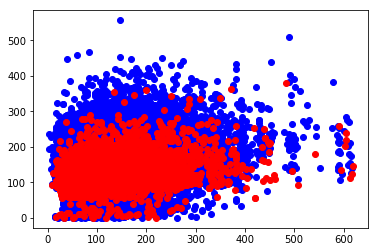

In [42]:
"""This is for seeing the relationship between context size and relevancy scores"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt


pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

trueData = []
falseData = []

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
        
        # get the most relevant of the anchors for each mention
        topCands = generateCandidates(line, 1, oText)
        # also get the context length of each mention
        ctxLens = []
        
        i = 0 # track which mention
        for mention in line['mentions']:
            # if no relevancy found
            if len(topCands[i]) <> 1:
                i += 1
                continue
                
            rel = topCands[i][0][2] 
            if rel < 210:
                things = sorted(anchor2concept(line['text'][mention[0]]), key = itemgetter(1), reverse = True)
                if len(things) >= 1:
                    topCands[i][0][0] = things[0][0]
            ctxLen = len(getMentionSentence(oText, mention))
            if topCands[i][0][0] == oMentions[i][2]:
                trueData.append([ctxLen, rel])
            else:
                falseData.append([ctxLen, rel])

            i += 1
            
        totalLines += 1
        
tLens = [item[0] for item in trueData]
fLens = [item[0] for item in falseData]
tRels = [item[1] for item in trueData]
fRels = [item[1] for item in falseData]

plt.plot(tLens, tRels, 'bo')
plt.plot(fLens, fRels, 'ro')
plt.show()

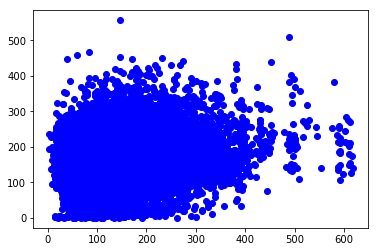

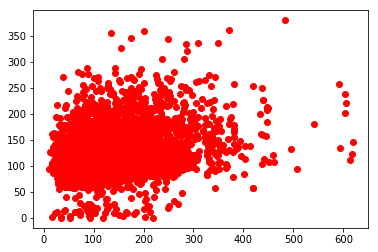

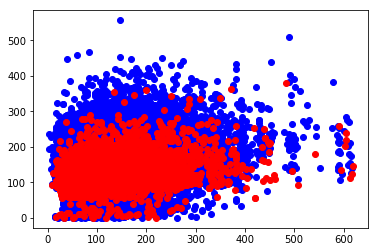

In [45]:
plt.clf()

plt.plot(tLens, tRels, 'bo')
plt.show()

plt.plot(fLens, fRels, 'ro')
plt.show()

plt.plot(tLens, tRels, 'bo')
plt.plot(fLens, fRels, 'ro')
plt.show()

In [46]:
val1 = 0
val2 = 0
total = len(trueData)
cutoff = 210
for item in trueData:
    if item[1] > cutoff:
        val1 += 1
for item in falseData:
    if item[1] > cutoff:
        val2 += 1
print val1
print val2
print total

4234
202
22610
